In [1]:
import matplotlib.pyplot as plt 
import scipy.misc
import json

import numpy as np
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, Cropping2D
from keras.layers import MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation, merge, GlobalAveragePooling2D
from keras.layers.merge import Add, Multiply, Average, Maximum, Concatenate, Dot
from keras.models import Model
from keras.utils.layer_utils import print_summary
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from scipy.misc import imread

from keras import __version__ as kv
from scipy import __version__ as sv
from matplotlib import __version__ as mv
from numpy import __version__ as nv

print(kv)
print(sv) 
print(mv) 
print(nv) 

Using TensorFlow backend.


2.0.7
0.19.0
2.0.0
1.12.1


In [2]:
# Local files
import utils_python3
#reload(utils_python3)

# Data

### Config

In [3]:
trained_model_dir = '/home/ubuntu/data/sar/training_crops_20170829/trained_models/deployed_models/'
train_dir = '/home/ubuntu/data/sar/training_crops_20170829/train/240x240/'
valid_dir = '/home/ubuntu/data/sar/training_crops_20170829/validate/240x240/'

In [4]:
input_shape = (240, 240, 1)
num_classes = 3

### Split training_crops json into train and validate

Done in 1.0-mph_kjd_as-Python3_binary_classifier_all_data_turbine.ipynb

### convert 240 tif to png

In [6]:
utils_python3.tif2png(src_dir=train_dir+"oil_and_gas_infrastructure/", dest_dir=train_dir+"oil_and_gas_infrastructure/")
utils_python3.tif2png(src_dir=train_dir+"other/", dest_dir=train_dir+"other/")
utils_python3.tif2png(src_dir=train_dir+"turbine/", dest_dir=train_dir+"turbine/")

/home/ubuntu/data/sar/training_crops_20170829/train/240x240/oil_and_gas_infrastructure/ 1756
/home/ubuntu/data/sar/training_crops_20170829/train/240x240/oil_and_gas_infrastructure/ 1756 3512
/home/ubuntu/data/sar/training_crops_20170829/train/240x240/other/ 2234
/home/ubuntu/data/sar/training_crops_20170829/train/240x240/other/ 2234 4468
/home/ubuntu/data/sar/training_crops_20170829/train/240x240/turbine/ 6198
/home/ubuntu/data/sar/training_crops_20170829/train/240x240/turbine/ 6198 12396


In [7]:
utils_python3.tif2png(src_dir=valid_dir+"oil_and_gas_infrastructure/", dest_dir=valid_dir+"oil_and_gas_infrastructure/")
utils_python3.tif2png(src_dir=valid_dir+"other/", dest_dir=valid_dir+"other/")
utils_python3.tif2png(src_dir=valid_dir+"turbine/", dest_dir=valid_dir+"turbine/")

/home/ubuntu/data/sar/training_crops_20170829/validate/240x240/oil_and_gas_infrastructure/ 501
/home/ubuntu/data/sar/training_crops_20170829/validate/240x240/oil_and_gas_infrastructure/ 501 1002
/home/ubuntu/data/sar/training_crops_20170829/validate/240x240/other/ 501
/home/ubuntu/data/sar/training_crops_20170829/validate/240x240/other/ 501 1002
/home/ubuntu/data/sar/training_crops_20170829/validate/240x240/turbine/ 501
/home/ubuntu/data/sar/training_crops_20170829/validate/240x240/turbine/ 501 1002


### Add dist2land feature and tif images

In [5]:
train_crops, train_filename, train_feature, train_class, \
valid_crops, valid_filename, valid_feature, valid_class = utils_python3.add_dist2land_training_crops_20170829_multiclass("240x240")

In [6]:
print("training crops:", len(train_crops))
print("training features:", len(train_feature))
print("validation crops:", len(valid_crops))
print("validation features:", len(valid_feature))
print(type(train_crops), type(train_crops[0]), train_crops[0].shape)

training crops: 10188
training features: 10188
validation crops: 1503
validation features: 1503
<class 'list'> <class 'numpy.ndarray'> (240, 240)


Quick check:

In [7]:
train_crops[0]

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 3, ..., 4, 4, 4],
       [2, 2, 2, ..., 3, 3, 3],
       ..., 
       [2, 3, 3, ..., 4, 5, 6],
       [2, 2, 2, ..., 3, 3, 3],
       [2, 1, 1, ..., 3, 2, 2]], dtype=uint8)

S1A_IW_GRDH_1SDV_20161019T060558_20161019T060623_013555_015B30_0BEA_terrain_correction_95.png [1, 0, 0]


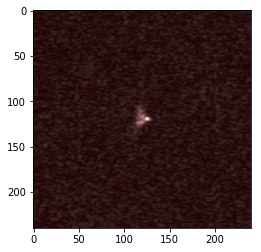

In [9]:
print(train_filename[0], train_class[0])
plt.imshow( train_crops[0], cmap='pink')
plt.show()

In [19]:
for idx, filename in enumerate(train_filename):
    if filename == "S1B_IW_GRDH_1SDV_20170402T062954_20170402T063019_004978_008B46_5DB6_terrain_correction_82.png":
        print(idx)

6481


S1B_IW_GRDH_1SDV_20170402T062954_20170402T063019_004978_008B46_5DB6_terrain_correction_82.png [0, 1, 0]


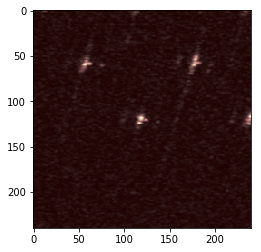

In [21]:
print(train_filename[6481], train_class[6481])
plt.imshow( train_crops[6481], cmap='pink')
plt.show()

S1A_IW_GRDH_1SDV_20170725T174107_20170725T174132_017631_01D826_3598_subset7_20.png [0, 0, 1]


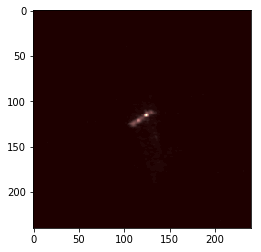

In [12]:
print(train_filename[10001], train_class[10001])
plt.imshow( train_crops[10001], cmap='pink')
plt.show()

In [13]:
# Reshape for keras format
np_train_class = np.array(train_class)
np_train_filename = np.array(train_filename)
np_train_crops = np.array(train_crops)
np_train_feature = np.array(train_feature)

np_valid_class = np.array(valid_class)
np_valid_filename = np.array(valid_filename)
np_valid_crops = np.array(valid_crops)
np_valid_feature = np.array(valid_feature)

np_train_crops = np.expand_dims(np_train_crops, axis=3)
np_train_feature = np.expand_dims(np_train_feature, axis=1)

np_valid_crops = np.expand_dims(np_valid_crops, axis=3)
np_valid_feature = np.expand_dims(np_valid_feature, axis=1)

In [14]:
print(np_train_crops.shape)
print(np_train_feature.shape)
print(np_train_class.shape)
print(np_valid_crops.shape)
print(np_valid_feature.shape)
print(np_valid_class.shape)

(10188, 240, 240, 1)
(10188, 1)
(10188, 3)
(1503, 240, 240, 1)
(1503, 1)
(1503, 3)


# Experiments

with distance

In [15]:
p = 0

classifier_input = Input(shape=input_shape)
dist2land_input = Input(shape=(1,))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# # Following based on https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb
x = BatchNormalization(axis=-1)(x)
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(3,(3,3), padding='same')(x)
x = Dropout(p)(x)
x = GlobalAveragePooling2D()(x)
m = Add()([dist2land_input, x])
out = Activation('softmax')(m)


model_with_distance = Model(inputs=[classifier_input, dist2land_input], outputs=out)
model_with_distance.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model_with_distance.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 240, 240, 1)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 240, 240, 32)  320         input_1[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 120, 120, 32)  0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 120, 120, 64)  18496       max_pooling2d_1[0][0]            
___________________________________________________________________________________________

In [17]:
lr = 0.001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 10188 samples, validate on 1503 samples
Epoch 1/10
10188/10188 [==============================] - 73s - loss: 0.2672 - acc: 0.8983 - val_loss: 0.3332 - val_acc: 0.8716
Epoch 2/10
10188/10188 [==============================] - 70s - loss: 0.1548 - acc: 0.9528 - val_loss: 0.1347 - val_acc: 0.9534
Epoch 3/10
10188/10188 [==============================] - 71s - loss: 0.1014 - acc: 0.9678 - val_loss: 1.1966 - val_acc: 0.5842
Epoch 4/10
10188/10188 [==============================] - 71s - loss: 0.0901 - acc: 0.9734 - val_loss: 0.2547 - val_acc: 0.8995
Epoch 5/10
10188/10188 [==============================] - 71s - loss: 0.0792 - acc: 0.9757 - val_loss: 0.5313 - val_acc: 0.8643
Epoch 6/10
10188/10188 [==============================] - 71s - loss: 0.0667 - acc: 0.9784 - val_loss: 0.1425 - val_acc: 0.9521
Epoch 7/10
10188/10188 [==============================] - 71s - loss: 0.0630 - acc: 0.9806 - val_loss: 0.5135 - val_acc: 0.8496
Epoch 8/10
10188/10188 [==============================]

In [18]:
lr = 0.0001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 10188 samples, validate on 1503 samples
Epoch 1/10
10188/10188 [==============================] - 71s - loss: 0.0208 - acc: 0.9938 - val_loss: 0.0847 - val_acc: 0.9807
Epoch 2/10
10188/10188 [==============================] - 71s - loss: 0.0118 - acc: 0.9965 - val_loss: 0.0857 - val_acc: 0.9807
Epoch 3/10
10188/10188 [==============================] - 71s - loss: 0.0086 - acc: 0.9973 - val_loss: 0.0852 - val_acc: 0.9807
Epoch 4/10
10188/10188 [==============================] - 71s - loss: 0.0075 - acc: 0.9983 - val_loss: 0.0878 - val_acc: 0.9807
Epoch 5/10
10188/10188 [==============================] - 71s - loss: 0.0060 - acc: 0.9986 - val_loss: 0.0883 - val_acc: 0.9827
Epoch 6/10
10188/10188 [==============================] - 71s - loss: 0.0048 - acc: 0.9991 - val_loss: 0.0942 - val_acc: 0.9814
Epoch 7/10
10188/10188 [==============================] - 71s - loss: 0.0041 - acc: 0.9992 - val_loss: 0.0899 - val_acc: 0.9814
Epoch 8/10
10188/10188 [==============================]

In [20]:
lr = 0.00001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=3,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 10188 samples, validate on 1503 samples
Epoch 1/3
10188/10188 [==============================] - 71s - loss: 0.0017 - acc: 0.9997 - val_loss: 0.1027 - val_acc: 0.9820
Epoch 2/3
10188/10188 [==============================] - 71s - loss: 0.0019 - acc: 0.9997 - val_loss: 0.1023 - val_acc: 0.9820
Epoch 3/3
10188/10188 [==============================] - 71s - loss: 0.0016 - acc: 0.9997 - val_loss: 0.1036 - val_acc: 0.9820


### Save model

In [22]:
model_with_distance.save(trained_model_dir+'/1.1-as_mph-Python3_FCN_240x240__full-png.h5')

In [23]:
model_json = model_with_distance.to_json()

with open(trained_model_dir+'/1.1-as_mph-Python3_FCN_240x240__architecture_only-png.json', 'w') as outfile:
    json.dump(model_json, outfile)

In [24]:
model_with_distance.save_weights(trained_model_dir+'/1.1-as_mph-Python3_FCN_240x240__weights_only-png.h5')